### Applying example from week 5, for MaritalStatus

In [60]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
palette = itertools.cycle(sns.color_palette())

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Load the data set
data = pd.read_csv('train_processed.csv')

In [62]:
data.columns

Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Human Resources', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'Education

Lets now preprocess the data by:
- Separating the inputs (x) from the targets (y)
- Standardizing the input variables in order to have zero mean and unit standard deviation

In [63]:
# Separate between features/inputs (X) and target/output variables (y)
mat = data.values
X = np.delete(mat, 13, axis=1)
print(X.shape)
y = mat[:, 13].astype("int")
print(y.shape)
ind = mat[:,1].astype("int")  #and get the indexes
print(ind.shape)

(1058, 51)
(1058,)
(1058,)


In [64]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

The next step is to split our data into a train and test set. Alternatively, we could have used something like cross-validation, but for the sake of simplicity, a train/test split will do just fine for this example.

In [65]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 698
num test: 360


Just for the sake of comparision, lets run logistic regression from the popular sklearn package.

In [66]:
from sklearn.impute import SimpleImputer

# Create imputer (mean strategy works well for most numeric data)
imputer = SimpleImputer(strategy='mean')

# Fit to training data and transform both train and test
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [67]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [3 3 1 1 1 1 1 1 3 1 1 3 2 3 3 1 3 3 1 1 3 1 3 3 1 3 3 2 1 3 1 3 1 1 1 3 1
 2 1 1 3 3 2 2 1 1 3 2 3 1 3 1 3 3 1 3 2 3 3 3 2 1 3 2 1 3 1 1 1 3 3 2 1 3
 1 1 2 3 2 1 2 1 1 3 3 1 1 3 1 3 2 3 3 2 1 3 3 2 3 3 1 3 3 1 3 1 3 1 1 3 1
 3 3 3 1 2 3 3 3 3 3 2 1 2 3 1 1 3 2 1 3 1 1 3 3 1 3 3 3 3 3 1 2 3 3 3 3 1
 3 1 1 1 1 1 1 1 1 1 3 3 3 3 2 3 1 3 3 3 3 1 3 3 1 3 2 1 1 3 3 2 1 2 1 1 2
 1 3 1 3 2 1 3 1 3 3 3 1 2 1 3 1 3 3 3 1 1 1 3 3 3 2 1 3 3 1 3 3 3 3 1 3 1
 3 1 2 3 3 1 1 1 1 1 1 3 2 1 2 2 3 1 1 3 3 1 3 3 3 3 3 1 1 3 3 1 3 1 3 1 1
 2 3 1 1 3 3 3 1 3 1 1 1 3 2 1 1 1 3 2 3 1 3 1 3 3 1 1 3 3 3 3 2 3 2 3 3 3
 3 3 1 3 3 3 2 1 1 3 2 3 1 3 1 1 2 3 1 1 3 1 1 3 1 1 1 3 1 3 2 3 3 3 2 3 1
 1 1 3 1 1 3 2 3 1 3 1 1 1 3 3 1 3 3 3 1 3 2 3 3 3 3 3]
true values: [2 3 1 3 3 1 1 3 1 1 1 2 3 3 3 3 3 3 1 1 3 1 3 3 1 2 3 3 3 3 1 2 1 1 3 3 3
 2 1 1 3 3 3 3 1 1 3 3 3 1 2 3 3 3 1 3 2 2 2 1 3 1 2 3 1 2 3 3 1 3 2 3 1 2
 1 1 3 2 3 1 2 1 1 3 3 1 1 1 1 3 3 2 3 2 1 3 2 3 3 2 3 3 2 1 3 3 3 1 3 2 1
 2 3 1 3 3 3 1 3 3

In [68]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [69]:
n_cat = 3
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [70]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 40000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

#y_train = y_train.long()

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train-1)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 7031.6
[1000] ELBO: 2950.8
[2000] ELBO: 1221.0
[3000] ELBO: 943.4
[4000] ELBO: 901.0
[5000] ELBO: 882.2
[6000] ELBO: 883.6
[7000] ELBO: 865.1
[8000] ELBO: 843.9
[9000] ELBO: 855.4
[10000] ELBO: 843.7
[11000] ELBO: 838.8
[12000] ELBO: 842.7
[13000] ELBO: 835.0
[14000] ELBO: 854.2
[15000] ELBO: 849.5
[16000] ELBO: 845.0
[17000] ELBO: 851.8
[18000] ELBO: 836.0
[19000] ELBO: 830.4
[20000] ELBO: 830.4
[21000] ELBO: 819.1
[22000] ELBO: 811.2
[23000] ELBO: 824.2
[24000] ELBO: 828.8
[25000] ELBO: 826.0
[26000] ELBO: 816.7
[27000] ELBO: 824.1
[28000] ELBO: 822.0
[29000] ELBO: 826.4
[30000] ELBO: 809.6
[31000] ELBO: 816.1
[32000] ELBO: 831.6
[33000] ELBO: 836.7
[34000] ELBO: 800.0
[35000] ELBO: 809.4
[36000] ELBO: 827.5
[37000] ELBO: 803.1
[38000] ELBO: 806.5
[39000] ELBO: 796.3


Upon convergence, we can use the ```Predictive``` class to extract samples from posterior

In [72]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train)

Plot posterior distributions for the parameters using the ```seaborn``` package

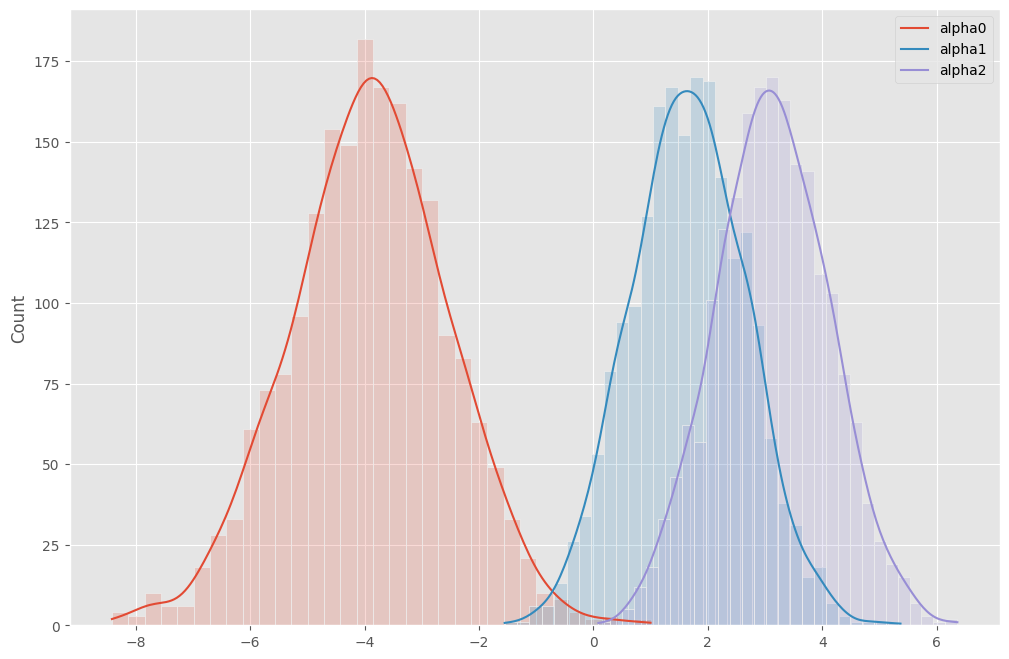

In [73]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

IndexError: index 48 is out of bounds for dimension 1 with size 48

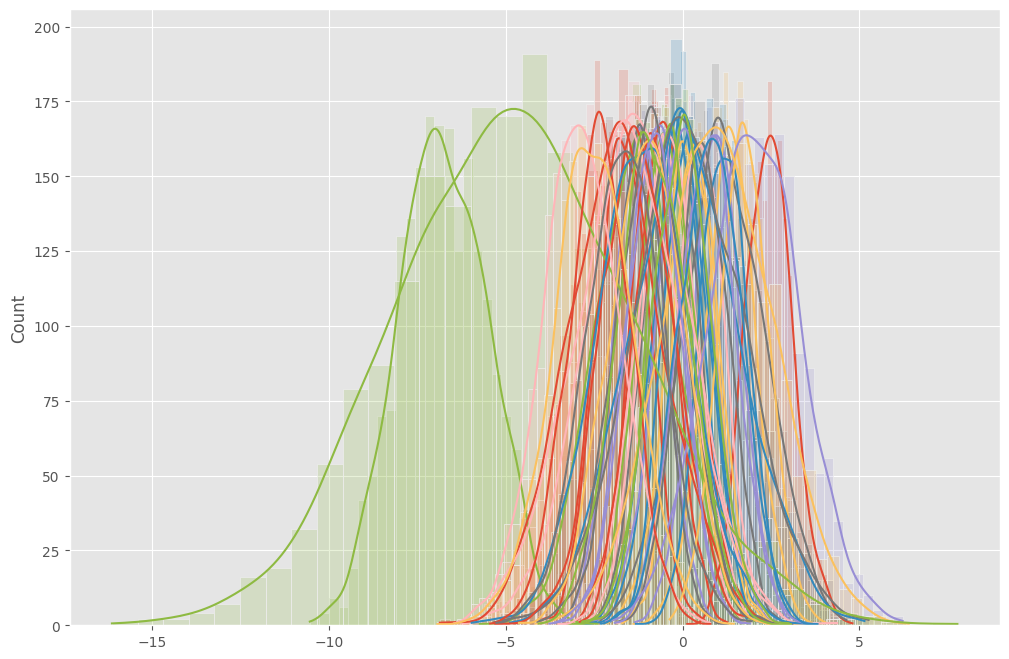

In [74]:
samples_beta = samples['beta'].detach().squeeze()
for d in range(X.shape[1]):
    sns.histplot(samples_beta[:,d,0], kde=True, alpha=0.2)
plt.legend(["beta1_%d" % d for d in range(X.shape[1])])
plt.show()

We can now use the inferred posteriors to make predictions for the testset and compute the corresponding accuracy

In [75]:
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

In [76]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [3 3 1 1 1 1 1 1 3 1 1 3 3 3 3 1 3 3 1 1 3 1 3 3 1 3 3 2 1 3 1 3 1 1 1 3 1
 2 1 1 3 3 2 2 1 1 3 2 3 1 3 1 3 3 1 3 2 3 3 3 2 1 3 2 1 3 1 1 1 3 3 2 1 3
 3 1 2 3 2 1 2 1 1 3 3 1 1 3 1 3 2 3 3 2 1 3 3 2 3 3 1 3 3 1 3 1 3 1 1 3 1
 3 3 3 1 2 3 3 3 3 3 2 1 2 3 1 1 3 2 1 3 1 1 3 3 1 3 3 3 3 3 1 3 3 3 3 3 1
 3 1 1 1 1 1 1 1 1 1 3 3 3 3 2 3 1 3 3 3 3 1 3 3 1 3 2 1 1 3 3 2 1 2 1 3 2
 1 3 1 3 2 1 2 1 3 3 3 1 2 1 3 1 3 3 3 1 1 1 3 3 3 2 1 3 3 1 3 3 3 3 1 3 1
 3 1 2 3 3 1 1 1 1 1 1 3 2 1 2 2 3 1 1 3 3 1 3 3 3 3 3 1 1 3 3 1 3 1 3 1 1
 2 3 1 1 3 3 3 1 3 1 1 1 3 2 1 1 1 3 2 3 1 3 1 3 3 1 1 3 3 3 3 2 3 2 3 3 3
 3 3 1 3 3 3 2 1 1 3 2 3 1 3 1 1 2 3 1 1 3 1 1 3 1 1 1 3 1 3 2 3 3 3 2 3 1
 1 1 3 1 1 3 2 3 1 3 1 1 1 3 3 1 3 3 3 1 3 2 3 3 3 3 3]
true values: [2 3 1 3 3 1 1 3 1 1 1 2 3 3 3 3 3 3 1 1 3 1 3 3 1 2 3 3 3 3 1 2 1 1 3 3 3
 2 1 1 3 3 3 3 1 1 3 3 3 1 2 3 3 3 1 3 2 2 2 1 3 1 2 3 1 2 3 3 1 3 2 3 1 2
 1 1 3 2 3 1 2 1 1 3 3 1 1 1 1 3 3 2 3 2 1 3 2 3 3 2 3 3 2 1 3 3 3 1 3 2 1
 2 3 1 3 3 3 1 3 3

You should have obtained a similar accuracy to sklearn, or even better...

Moreover, you now have full posterior distributions for the model parameters. Therefore, you can see how each trip characteristic affects the travel mode choices, but also how uncertain the model is about that relationship. For example, a very wide posterior distribution of a coefficient $\beta$ around 3, would tell you that, on average, the corresponding variables contributes positively to a having preference for a given mode, but the model is not very confident about that conclusion.

### Inference with MCMC

Lastly, for the sake of completeness, we show below how to approximate Bayesian inference in the model using MCMC. However, we note that the code below takes a while (approx. 10 minutes) to run.

In [77]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=1)
mcmc.run(X_train, n_cat, y_train-1) # Pyro accepts categories starting from 0

Sample: 100%|██████████| 600/600 [06:21,  1.57it/s, step size=8.80e-03, acc. prob=0.900]


In [78]:
samples = mcmc.get_samples()
alpha_hat = samples["alpha"].detach().squeeze().mean(axis=0).numpy()
beta_hat = samples["beta"].detach().squeeze().mean(axis=0).numpy()

In [79]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [3 3 1 1 1 1 1 1 3 1 1 3 2 3 3 1 3 3 1 1 3 1 3 3 3 3 3 2 1 3 1 3 1 1 1 3 1
 2 1 1 3 3 2 2 1 1 3 2 3 1 3 1 3 3 1 3 2 3 3 3 2 1 3 2 1 3 1 1 1 3 3 2 1 3
 3 1 2 3 2 1 2 1 1 3 3 1 1 3 1 3 2 3 3 2 1 3 3 2 3 3 1 3 3 1 3 1 3 1 1 3 1
 3 3 3 1 2 3 3 3 3 3 2 1 2 3 1 1 3 2 1 3 1 1 3 3 1 3 3 3 3 3 1 2 3 3 3 3 1
 3 1 1 1 1 1 1 1 1 1 3 3 3 3 2 3 1 3 3 3 3 1 3 3 1 3 2 1 1 3 3 2 1 2 1 3 2
 1 3 1 3 2 1 2 1 3 3 3 1 2 1 3 1 3 3 3 1 1 1 3 3 3 2 1 3 3 1 3 3 3 3 1 3 1
 3 1 2 3 3 1 1 1 1 1 1 3 2 1 2 2 3 1 1 3 3 1 3 3 3 3 3 1 1 2 3 1 3 1 3 1 1
 2 3 1 3 3 3 3 1 3 1 1 1 2 2 1 1 1 3 2 3 1 3 1 3 3 1 1 3 3 3 3 2 3 2 3 3 3
 3 3 1 3 3 3 2 1 1 3 2 3 1 3 1 1 2 3 1 1 3 1 1 3 1 1 1 3 1 3 2 3 3 3 2 3 1
 1 1 3 1 1 3 2 3 1 3 1 1 1 3 3 1 3 3 3 1 3 2 3 3 3 3 3]
true values: [2 3 1 3 3 1 1 3 1 1 1 2 3 3 3 3 3 3 1 1 3 1 3 3 1 2 3 3 3 3 1 2 1 1 3 3 3
 2 1 1 3 3 3 3 1 1 3 3 3 1 2 3 3 3 1 3 2 2 2 1 3 1 2 3 1 2 3 3 1 3 2 3 1 2
 1 1 3 2 3 1 2 1 1 3 3 1 1 1 1 3 3 2 3 2 1 3 2 3 3 2 3 3 2 1 3 3 3 1 3 2 1
 2 3 1 3 3 3 1 3 3